In [24]:
%load_ext lab_black

from puzzles import load

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [25]:
import numpy as np

In [154]:
import matplotlib.pyplot as plt

In [35]:
def correct_idx(i, j, shape):
    return np.clip(i, 0, shape[0]), np.clip(j, 0, shape[1])

In [44]:
def disp(array):
    return "\n".join(["".join([".|#"[x] for x in line]) for line in array])

In [47]:
ground_truth = [
    """.......##.
......|###
.|..|...#.
..|#||...#
..##||.|#|
...#||||..
||...|||..
|||||.||.|
||||||||||
....||..|.""",
    """.......#..
......|#..
.|.|||....
..##|||..#
..###|||#|
...#|||||.
|||||||||.
||||||||||
||||||||||
.|||||||||""",
    """.......#..
....|||#..
.|.||||...
..###|||.#
...##|||#|
.||##|||||
||||||||||
||||||||||
||||||||||
||||||||||""",
    """.....|.#..
...||||#..
.|.#||||..
..###||||#
...###||#|
|||##|||||
||||||||||
||||||||||
||||||||||
||||||||||""",
    """....|||#..
...||||#..
.|.##||||.
..####|||#
.|.###||#|
|||###||||
||||||||||
||||||||||
||||||||||
||||||||||""",
    """...||||#..
...||||#..
.|.###|||.
..#.##|||#
|||#.##|#|
|||###||||
||||#|||||
||||||||||
||||||||||
||||||||||""",
    """...||||#..
..||#|##..
.|.####||.
||#..##||#
||##.##|#|
|||####|||
|||###||||
||||||||||
||||||||||
||||||||||""",
    """..||||##..
..|#####..
|||#####|.
||#...##|#
||##..###|
||##.###||
|||####|||
||||#|||||
||||||||||
||||||||||""",
    """..||###...
.||#####..
||##...##.
||#....###
|##....##|
||##..###|
||######||
|||###||||
||||||||||
||||||||||""",
    """.||##.....
||###.....
||##......
|##.....##
|##.....##
|##....##|
||##.####|
||#####|||
||||#|||||
||||||||||""",
]

---

In [52]:
def rule(k, center=[1, 1]):
    # An open acre will become filled with trees if three or more
    # adjacent acres contained trees. Otherwise, nothing happens.
    if k[center[0], center[1]] == 0:
        return int((k == 1).sum() >= 3)

    # An acre filled with trees will become a lumberyard if three
    # or more adjacent acres were lumberyards. Otherwise, nothing happens.
    if k[center[0], center[1]] == 1:
        return int((k == 2).sum() >= 3) + 1

    # An acre containing a lumberyard will remain a lumberyard if it was
    # adjacent to at least one other lumberyard and at least one acre
    # containing trees. Otherwise, it becomes open.
    if k[center[0], center[1]] == 2:
        return int((k == 1).sum() >= 1 and ((k == 2).sum() - 1) >= 1) * 2

In [62]:
def build(s):
    return np.array(
        [[".|#".index(c) for c in x] for x in s.strip().split("\n")]
    ).astype(np.uint8)

In [95]:
def step(A, B=None):
    if B is None:
        B = np.zeros_like(A, dtype=A.dtype)
    for i in range(len(A)):
        for j in range(len(A[1])):
            i0, j0 = correct_idx(i - 1, j - 1, A.shape)
            i1, j1 = correct_idx(i + 2, j + 2, A.shape)
            ic = int(i != 0)
            jc = int(j != 0)
            B[i, j] = rule(A[i0:i1, j0:j1], center=(ic, jc))
    return B

In [102]:
s = """.#.#...|#.
.....#|##|
.|..|...#.
..|#.....#
#.#|||#|#|
...#.||...
.|....|...
||...#|.#|
|.||||..|.
...#.|..|."""

A = build(s)
B = np.zeros_like(A, dtype=A.dtype)

for i in range(len(ground_truth) - 1):
    print(disp(step(build(ground_truth[i]), B)) == disp(build(ground_truth[i + 1])))

True
True
True
True
True
True
True
True
True


In [108]:
from tqdm import tqdm

In [113]:
s = load(18)

A = build(s)
B = np.zeros_like(A, dtype=A.dtype)

for _ in tqdm(range(10)):
    A = step(A)

(A == 2).sum() * (A == 1).sum()

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.55it/s]


466312

---

In [138]:
from numba import jit

In [143]:
@jit(nopython=True)
def step(A, B=None):
    if B is None:
        B = np.zeros_like(A, dtype=A.dtype)
    for i in range(len(A)):
        for j in range(len(A[1])):
            i0, j0 = max(i - 1, 0), max(j - 1, 0)
            i1, j1 = min(i + 2, A.shape[0]), min(j + 2, A.shape[1])
            ic = int(i != 0)
            jc = int(j != 0)
            k = A[i0:i1, j0:j1]
            if k[ic, jc] == 0:
                val = int((k == 1).sum() >= 3)
            elif k[ic, jc] == 1:
                val = int((k == 2).sum() >= 3) + 1
            elif k[ic, jc] == 2:
                val = int((k == 1).sum() >= 1 and ((k == 2).sum() - 1) >= 1) * 2
            B[i, j] = val
    return B

In [159]:
s = load(18)

A = build(s)
B = np.zeros_like(A, dtype=A.dtype)

vals = []
for i in tqdm(range(2000)):
    if i % 2 == 0:
        B = step(A, B)
    else:
        A = step(B, A)
    vals.append((A == 2).sum() * (A == 1).sum())

100%|██████████████████████████████████████| 2000/2000 [00:02<00:00, 978.32it/s]


In [160]:
vals = np.array(vals)

In [167]:
(1000000000 - 1000) % 28

0

In [168]:
vals[1000]

176782

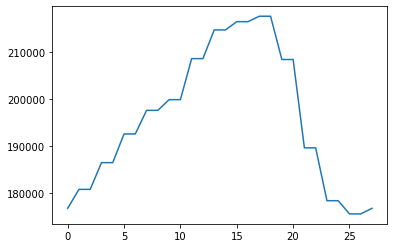

In [166]:
plt.plot([vals[1000 + T] for T in range(28)])

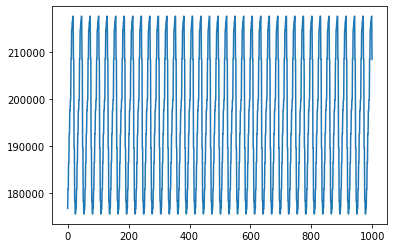

In [163]:
plt.plot(vals[1000:])

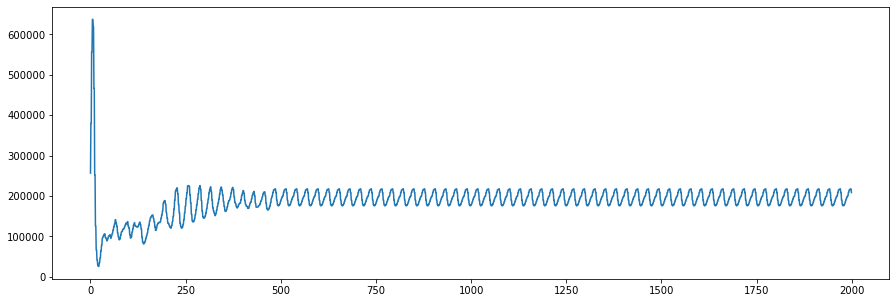

In [161]:
plt.figure(figsize=(15, 5))
plt.plot(vals)

In [169]:
s = load(18)

A = build(s)
B = np.zeros_like(A, dtype=A.dtype)

for i in tqdm(range(600)):
    if i % 2 == 0:
        B = step(A, B)
    else:
        A = step(B, A)

100%|████████████████████████████████████████| 600/600 [00:00<00:00, 991.59it/s]


In [170]:
import time

In [ ]:
for i in tqdm(range(28)):
    if i % 2 == 0:
        B = step(A, B)
        print(disp(B))
    else:
        A = step(B, A)
        print(disp(A))
    print()